# Supplementary Code 2

## Loading and labeling Olivetti dataset faces

This code was adopted from http://flothesof.github.io/smile-recognition.html.  The database comes from AT&T's "ORL Database of Faces" - http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html.  A reference is available from F.S. Samaria and A.C. Harter, "Parameterisation of a stochastic model for human face identification." *Applications of Computer Vision*, 1994., Proceedings of the Second IEEE Workshop on. IEEE, 1994.

In [1]:
# set the backend of matplotlib to the 'inline' backend
%matplotlib inline 

# import time-related functions to time code snippets
import time

# import pylab packages
from pylab import *

# import datasets from sklearn and fetch Olivetti faces
from sklearn import datasets
faces = datasets.fetch_olivetti_faces()

Plot first 15 faces from dataset to ensure it loaded correctly.

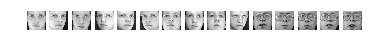

In [2]:
for i in range(15):
    face = faces.images[i]
    subplot(1, 15, i + 1)
    imshow(face.reshape((64, 64)), cmap='gray')
    axis('off')

Build a GUI to classify the 400 faces into "happy" or "not happy" categories.

In [3]:
import ipywidgets as widgets # import widgets for button
from IPython.display import display, clear_output # import clear_output

In [4]:
class Trainer:
    def __init__(self):
        self.results = {}
        self.imgs = faces.images
        self.index = 0
        
    def increment_face(self):
        if self.index + 1 >= len(self.imgs):
            return self.index
        else:
            while str(self.index) in self.results:
                print(self.index)
                self.index += 1
            return self.index
    
    def record_result(self, happy=True):
        self.results[str(self.index)] = happy

In [5]:
trainer = Trainer()

Button(description='HAPPY', style=ButtonStyle())

Button(description='NOT HAPPY', style=ButtonStyle())

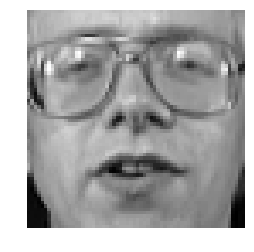

In [6]:
button_happy = widgets.Button(description='HAPPY')
button_not_happy = widgets.Button(description='NOT HAPPY')

def display_face(face):
    clear_output()
    display(button_happy)
    display(button_not_happy)
    imshow(face, cmap='gray')
    axis('off')

def update_happy(b):
    trainer.record_result(happy=True)
    trainer.increment_face()
    display_face(trainer.imgs[trainer.index])

def update_not_happy(b):
    trainer.record_result(happy=False)
    trainer.increment_face()
    display_face(trainer.imgs[trainer.index])

button_not_happy.on_click(update_not_happy)
button_happy.on_click(update_happy)


display_face(trainer.imgs[trainer.index])

In [7]:
# save data periodically to avoid losing results
import json
with open('results.xml', 'w') as f:
    json.dump(trainer.results, f)

In [8]:
# load complete data training from xml file
import json
results = json.load(open('results_20171124.xml'))
trainer.results = results

Create bar plot to show number of "happy" and number of "not happy" faces.

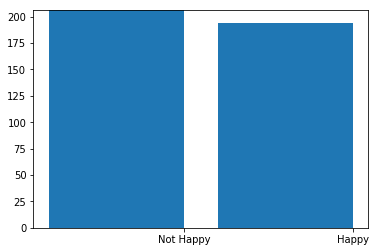

In [9]:
yes, no = (sum([trainer.results[x] == True for x in trainer.results]), 
            sum([trainer.results[x] == False for x in trainer.results]))
bar([0, 1], [no, yes])
ylim(0, max(yes, no))
xticks([0.4, 1.4], ['Not Happy', 'Happy']);

Display the images of all the classified "happy" faces. 

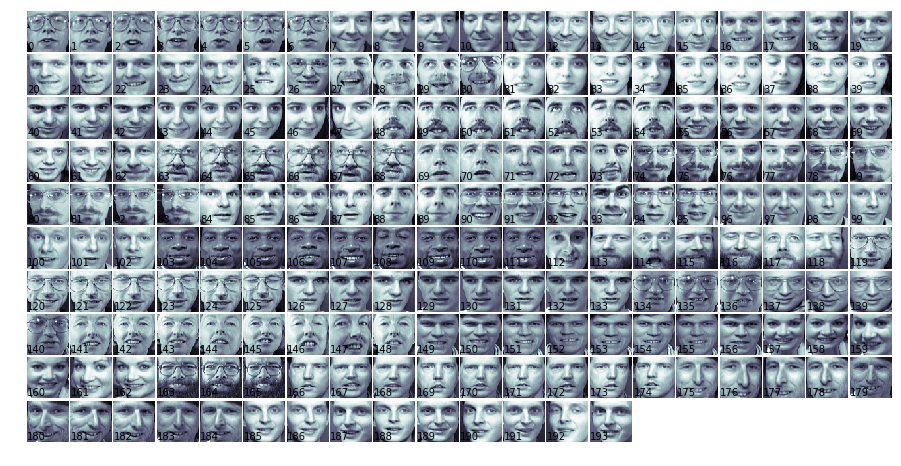

In [10]:
happy_indices = [int(i) for i in results if results[i] == True]

fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(len(happy_indices)):
    # plot the images in a matrix of 20x20
    p = fig.add_subplot(20, 20, i + 1)
    p.imshow(faces.images[happy_indices[i]], cmap=plt.cm.bone)
    
    # label the image with the target value
    #p.text(0, 14, "happy")
    p.text(0, 60, str(i))
    p.axis('off')

Display the images of all the classified "not happy" faces. 

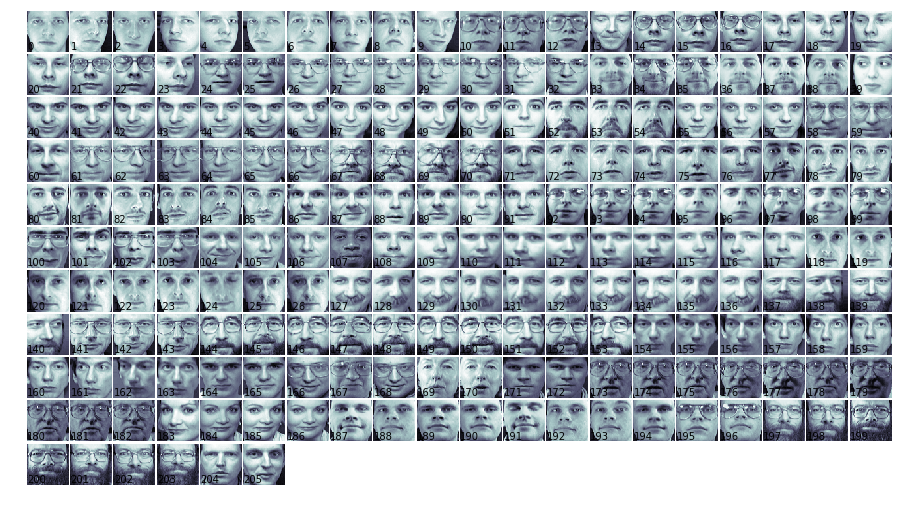

In [11]:
not_happy_indices = [int(i) for i in results if results[i] == False]

fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(len(not_happy_indices)):
    # plot the images in a matrix of 20x20
    p = fig.add_subplot(20, 20, i + 1)
    p.imshow(faces.images[not_happy_indices[i]], cmap=plt.cm.bone)

    # label the image with the target value
    #p.text(0, 11, "not")
    p.text(0, 60, str(i))
    p.axis('off')

# Supplementary Code 3
## Training the Support Vector Machine Classifier
This code was adopted from http://flothesof.github.io/smile-recognition.html

In [12]:
# import support vector classifier
from sklearn.svm import SVC
# we are using linear support vector classification
svc_1 = SVC(kernel='linear') 

# load image data
indices = [i for i in trainer.results]
data = faces.data[0:400, :]

# assign traget vectors [1 = "happy, 0 = "not happy"]
target = [trainer.results[i] for i in trainer.results]
target = array(target).astype(int32)

Train the classifier using k-fold cross validation

In [13]:
# import train_test_split to partition data
from sklearn.cross_validation import train_test_split 

# import cross_val_score and Kfold functions
from sklearn.cross_validation import cross_val_score, KFold

# import standard error of mean function
from scipy.stats import sem

# partition data 
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.25, random_state=0)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [14]:
# define function for cross-validation

def evaluate_cross_validation(clf, X, y, K):
    # create a k-fold cross validation iterator
    cv = KFold(len(y), K, shuffle=True, random_state=0)
    # by default the score used is the one returned by score method of the estimator (accuracy)
    scores = cross_val_score(clf, X, y, cv=cv)
    print (scores)
    print ("Mean score: {0:.3f} (+/-{1:.3f})".format(
        np.mean(scores), sem(scores)))

Evaluate classifier's performance

In [15]:
evaluate_cross_validation(svc_1, X_train, y_train, 5)

[ 0.81666667  0.75        0.76666667  0.7         0.81666667]
Mean score: 0.770 (+/-0.022)


Prepare confusion matrix

In [16]:
from sklearn import metrics

def train_and_evaluate(clf, X_train, X_test, y_train, y_test):
    
    clf.fit(X_train, y_train)
    
    print ("Accuracy on training set:")
    print (clf.score(X_train, y_train))
    print ("Accuracy on testing set:")
    print (clf.score(X_test, y_test))
    
    y_pred = clf.predict(X_test)
    
    print ("Confusion Matrix:")
    print (metrics.confusion_matrix(y_test, y_pred))

In [17]:
train_and_evaluate(svc_1, X_train, X_test, y_train, y_test)

Accuracy on training set:
1.0
Accuracy on testing set:
0.71
Confusion Matrix:
[[38 10]
 [19 33]]


Create GUI to visually assess the performance of the classifier.

In [18]:
random_image_button = widgets.Button(description='New Image!')

def display_face_and_prediction(b):
    index = randint(0, 400)
    face = faces.images[index]
    imshow(face, cmap='gray')
    print("Image Index:", index)
    B = face.reshape(1, -1)
    print("This person is happy", "\n[0 = NO; 1 = YES]:", svc_1.predict(B))
    
random_image_button.on_click(display_face_and_prediction)
display(random_image_button)

Button(description='New Image!', style=ButtonStyle())

# Supplementary Code 4

## Adaptive Costume Creation from Facial Feature Detection and Emotion Recogniton

This code was adopted from https://sublimerobots.com/2015/02/dancing-mustaches/

First we experimented with frontal and profile face detectors.

In [19]:
import numpy as np
import cv2
face_cascadeFrontal = cv2.CascadeClassifier('C:\opencv\sources\data\haarcascades\haarcascade_frontalface_default.xml')
face_cascadeProfile = cv2.CascadeClassifier('C:\opencv\sources\data\haarcascades\haarcascade_profileface.xml')
img = cv2.imread('5.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

facesFrontal = face_cascadeFrontal.detectMultiScale(gray, 1.3,5)
for (x,y,w,h) in facesFrontal:
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
       
facesProfile = face_cascadeProfile.detectMultiScale(gray, 1.3,5)
for (x,y,w,h) in facesProfile:
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]

    
cv2.imshow('img',img)
cv2.waitKey(0)
cv2.destroyAllWindows()

Next we experimented with a rotation invariant face detector

In [20]:
import numpy as np
import cv2

face_cascade = cv2.CascadeClassifier('C:\opencv\sources\data\haarcascades\haarcascade_frontalface_default.xml')

# load rotated image
img = cv2.imread('Lillian.JPG',0)
rows,cols = img.shape
for i in range(0,24):
    M = cv2.getRotationMatrix2D((cols/2,rows/2),i*15,1)
    dst = cv2.warpAffine(img,M,(cols,rows))
    
    faces = face_cascade.detectMultiScale(dst, 1.3,5)
    
    if len(faces) > 0:
        break
        
for (x,y,w,h) in faces:
    cv2.rectangle(dst,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = dst[y:y+h, x:x+w]
    roi_color = dst[y:y+h, x:x+w]


cv2.imshow('image',dst)
cv2.waitKey(0)
cv2.destroyAllWindows()

Afterwards we defined our functions for adaptive costume creation on static images

In [21]:
def detect_faceFrontal(frame):
    face_cascadeFrontal = cv2.CascadeClassifier('C:\opencv\sources\data\haarcascades\haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    facesFrontal = face_cascadeFrontal.detectMultiScale(gray, scaleFactor = 1.1, minNeighbors = 6, minSize = (100, 100))
    return gray, facesFrontal

def detect_eyesFrontal(roi_gray):
    eye_cascadeFrontal = cv2.CascadeClassifier('C:\opencv\sources\data\haarcascades\haarcascade_eye.xml')
    eyesFront = eye_cascadeFrontal.detectMultiScale(roi_gray, scaleFactor = 1.1)
    return eyesFront
    
def detect_nosesFrontal(roi_gray):
    nose_Cascade = cv2.CascadeClassifier('C:\opencv\sources\data\haarcascades\haarcascade_mcs_nose.xml')
    nosesFront = nose_Cascade.detectMultiScale(roi_gray, scaleFactor = 1.1)
    return nosesFront    

def detect_faceProfile(frame):
    face_cascadeProfile = cv2.CascadeClassifier('C:\opencv\sources\data\haarcascades\haarcascade_profileface.xml')
    grayProfile = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    facesProfile = face_cascadeProfile.detectMultiScale(gray, scaleFactor = 1.1, minNeighbors = 6, minSize = (100, 100))
    return grayProfile, facesProfile    
    
def extractFeatures(gray, x, y, w, h):
    horizontal_offset = int(0.15 *w) 
    vertical_offset = int(0.2 * h)
    extracted_face = gray[y+vertical_offset:y+h, x+horizontal_offset:x-horizontal_offset+w]        
    # transform extracted img to 64 x 65 to match feature format of Olivetti dataset faces.
    new_extracted_face = zoom(extracted_face, (64. / extracted_face.shape[0], 
                                           64. / extracted_face.shape[1]))    
    new_extracted_face = new_extracted_face.astype(float32)
    new_extracted_face /= float(new_extracted_face.max())
    return new_extracted_face    
    
def predict_face_is_happy(extracted_face):
    B = extracted_face.reshape(1, -1)
    return svc_1.predict(B)   
        
def right_vs_left_eyes(eyesFront):
    x = np.array(eyesFront[:,1]); x1 = sorted(x); eyCutoff = x1[1]
    range1 = len(eyesFront)
    list1 = []; list2 = []; list3 = []
    for i in range(len(eyesFront)):
        for j in range(len(eyesFront)):
            if eyesFront[i,1] <= eyCutoff and eyesFront[j,1] <= eyCutoff and i !=j:
                list1.append(i) 
                list2.append(j)
            list3.append(abs(eyesFront[i,1]-eyesFront[j,1]))
    m = min(i for i in list3) # y-dist between two closest pairs of eyes
    pos = list3.index(m) # find 
    firstEye = list1[pos];  secondEye = list2[pos]

    # Determine which of the two eyes are the left and right eyes
    if eyesFront[firstEye,0] < eyesFront[secondEye,0]:
        rightEye = firstEye; leftEye = secondEye
    else:
        rightEye = secondEye; leftEye = firstEye  
    return rightEye, leftEye
    
def piratePatchTwoEyes(eyesFront):
    # Load overlay PiratePatch image: piratePatch.png
    imgPiratePatch = cv2.imread('piratePatch.png',-1)
    # Create PiratePatch mask
    orig_maskPiratePatch = imgPiratePatch[:,:,2]
    # Create inverted PiratePatch mask for the PiratePatch
    orig_mask_invPiratePatch = cv2.bitwise_not(orig_maskPiratePatch)
    imgPiratePatch = imgPiratePatch[:,:,0:3]
    origPiratePatchHeight, origPiratePatchWidth = imgPiratePatch.shape[:2]

    # Create pirate eye PiratePatch over left eye 
    PiratePatchWidth =  eyesFront[leftEye,2] # pirate eye path should be the width of the eye
    PiratePatchHeight = PiratePatchWidth * origPiratePatchHeight / origPiratePatchWidth # scale PiratePatch height to maintain aspect ratio
    # Determine the eye PiratePatch bounding regions
    x1 = eyesFront[leftEye,0] - (PiratePatchWidth/4)
    x2 = eyesFront[leftEye,0] + eyesFront[leftEye,2] + (PiratePatchWidth/4)
    y1 = eyesFront[leftEye,1] - (PiratePatchHeight/4)
    y2 = eyesFront[leftEye,1] + eyesFront[leftEye,3] + (PiratePatchHeight/4)
    # Cast coordinates as integers 
    x1 = int(x1); x2 = int(x2); y1 = int(y1);  y2 = int(y2)
    # Check for clipping
    if x1 < 0:
        x1 = 0
    if y1 < 0:
        y1 = 0
    if x2 > w:
        x2 = w
    if y2 > h:
        y2 = h
    # Re-calculate eye PiratePatch width and height
    PiratePatchWidth = x2 - x1; PiratePatchHeight = y2 - y1;
    # Re-size the original PiratePatch image and the masks to the new PiratePatch size
    PiratePatch = cv2.resize(imgPiratePatch, (PiratePatchWidth,PiratePatchHeight), interpolation = cv2.INTER_AREA)
    mask = cv2.resize(orig_maskPiratePatch, (PiratePatchWidth,PiratePatchHeight), interpolation = cv2.INTER_AREA)
    mask_inv = cv2.resize(orig_mask_invPiratePatch, (PiratePatchWidth,PiratePatchHeight), interpolation = cv2.INTER_AREA)
    # take ROI for eye PiratePatch from background equal to size of path image
    roi = roi_color[y1:y2, x1:x2]
    # roi_bg contains the original image only where the PiratePatch is not ...
    # in the region that is the size of the PiratePatch.
    roi_bg = cv2.bitwise_and(roi,roi,mask = mask_inv)
    # roi_fg contains the image of the PiratePatch only where the path is
    roi_fg = cv2.bitwise_and(PiratePatch,PiratePatch,mask = mask)
    # join roi_bg and roi_fg
    dst = cv2.add(roi_bg,roi_fg)
    # place the joined image, saved to dst back over the original image
    roi_color[y1:y2, x1:x2] = dst  
    
def piratePatchOneEye(eyesFront):
    # Load overlay patch image: piratePatch.png
    imgPatch = cv2.imread('piratePatch.png',-1)
    # Create patch mask
    orig_maskPatch = imgPatch[:,:,2]
    # Create inverted patch mask for the patch
    orig_mask_invPatch = cv2.bitwise_not(orig_maskPatch)
    imgPatch = imgPatch[:,:,0:3]
    origPatchHeight, origPatchWidth = imgPatch.shape[:2]
    
    # add a pirate eye patch
    patchWidth =  eyesFront[0,2] # pirate eye path should be the width of the eye
    patchHeight = patchWidth * origPatchHeight / origPatchWidth # scale patch height to maintain aspect ratio
    # Determine the eye patch bounding regions
    x1 = eyesFront[0,0] - (patchWidth/4)
    x2 = eyesFront[0,0] + eyesFront[0,2] + (patchWidth/4)
    y1 = eyesFront[0,1] - (patchHeight/4)
    y2 = eyesFront[0,1] + eyesFront[0,3] + (0/4)
    # Cast coordinates as integers 
    x1 = int(x1); x2 = int(x2); y1 = int(y1);  y2 = int(y2)
    # Check for clipping
    if x1 < 0:
        x1 = 0
    if y1 < 0:
        y1 = 0
    if x2 > w:
        x2 = w
    if y2 > h:
        y2 = h
    # Re-calculate eye patch width and height
    patchWidth = x2 - x1; patchHeight = y2 - y1;
    # Re-size the original patch image and the masks to the new patch size
    patch = cv2.resize(imgPatch, (patchWidth,patchHeight), interpolation = cv2.INTER_AREA)
    mask = cv2.resize(orig_maskPatch, (patchWidth,patchHeight), interpolation = cv2.INTER_AREA)
    mask_inv = cv2.resize(orig_mask_invPatch, (patchWidth,patchHeight), interpolation = cv2.INTER_AREA)
    # take ROI for eye patch from background equal to size of path image
    roi = roi_color[y1:y2, x1:x2]
    # roi_bg contains the original image only where the patch is not ...
    # in the region that is the size of the patch.
    roi_bg = cv2.bitwise_and(roi,roi,mask = mask_inv)
    # roi_fg contains the image of the patch only where the patch is
    roi_fg = cv2.bitwise_and(patch,patch,mask = mask)
    # join roi_bg and roi_fg
    dst = cv2.add(roi_bg,roi_fg)
    # place the joined image, saved to dst back over the original image
    roi_color[y1:y2, x1:x2] = dst      
    
    
def pirateMustache(nx, ny, nw, nh):    
    # Load overlay mustache image: pirateMustache.png
    imgMustache = cv2.imread('pirateMustache.png',-1)
    # Create mustache mask
    orig_mask = imgMustache[:,:,3]
    # Create inverted mustache mask
    orig_mask_inv = cv2.bitwise_not(orig_mask)
    # Convert mustache img to BGR; and save original img size (used later when re-sizing img)
    imgMustache = imgMustache[:,:,0:3]
    origMustacheHeight, origMustacheWidth = imgMustache.shape[:2]

    # Create Mustache
    mustacheWidth =  3 * nw # mustache width is 3x nose width
    mustacheHeight = mustacheWidth * origMustacheHeight / origMustacheWidth # maintain mustache aspect ratio
    # Center mustache on bottom of nose
    x1 = nx - (mustacheWidth/4)
    x2 = nx + nw + (mustacheWidth/4)
    y1 = ny + nh - (mustacheHeight/2)
    y2 = ny + nh + (mustacheHeight/2)
    # Cast coordinates as integers
    x1 = int(x1); x2 = int(x2); y1 = int(y1);  y2 = int(y2)
    # Check for clipping
    if x1 < 0:
        x1 = 0
    if y1 < 0:
        y1 = 0
    if x2 > w:
        x2 = w
    if y2 > h:
        y2 = h
    # Re-calculate mustache width and height
    mustacheWidth = x2 - x1; mustacheHeight = y2 - y1
    # Re-size the original mustache img and the masks to the new mustache size
    mustache = cv2.resize(imgMustache, (mustacheWidth,mustacheHeight), interpolation = cv2.INTER_AREA)
    mask = cv2.resize(orig_mask, (mustacheWidth,mustacheHeight), interpolation = cv2.INTER_AREA)
    mask_inv = cv2.resize(orig_mask_inv, (mustacheWidth,mustacheHeight), interpolation = cv2.INTER_AREA)
    # take ROI for mustache from background equal to size of mustache image
    roi = roi_color[y1:y2, x1:x2]
    # roi_bg contains the original image only where the mustache is ...
    # ... not in the region that is the size of the mustache.
    roi_bg = cv2.bitwise_and(roi,roi,mask = mask_inv)
    # roi_fg contains the image of the mustache only where the mustache is
    roi_fg = cv2.bitwise_and(mustache,mustache,mask = mask)
    # join roi_bg and roi_fg
    dst = cv2.add(roi_bg,roi_fg)
    # place the joined image, saved to dst back over the original image
    roi_color[y1:y2, x1:x2] = dst

def pirateHat(x, y, w, h, img):    
    # Load overlay pirateHat image: pirateHat.png
    imgPirateHat = cv2.imread('pirateHat.png',-1)
    # Create pirateHat mask
    orig_mask = imgPirateHat[:,:,3]
    # Create inverted pirateHat mask
    orig_mask_inv = cv2.bitwise_not(orig_mask)
    # Convert pirateHat img to BGR; and save original img size (used later when re-sizing img)
    imgPirateHat = imgPirateHat[:,:,0:3]
    origPirateHatHeight, origPirateHatWidth = imgPirateHat.shape[:2]

    # Create pirateHat
    pirateHatWidth =  1 * w # pirateHat width is 3x nose width
    pirateHatHeight = pirateHatWidth * origPirateHatHeight / origPirateHatWidth # maintain pirateHat aspect ratio
    # Center pirateHat on bottom of nose
    x1 = x - (pirateHatWidth/8)
    x2 = x + w + (pirateHatWidth/8)
    y1 = y - (pirateHatHeight/1.5)
    y2 = y + (pirateHatHeight/4)
    # Cast coordinates as integers
    x1 = int(x1); x2 = int(x2); y1 = int(y1);  y2 = int(y2)
    # Check for clipping
    if x1 < 0:
        x1 = 0
    if y1 < 0:
        y1 = 0
    if x2 > img.shape[1]:
        x2 = img.shape[1]
    if y2 > img.shape[0]:
        y2 = img.shape[0]
    # Re-calculate pirateHat width and height
    pirateHatWidth = x2 - x1; pirateHatHeight = y2 - y1
    # Re-size the original pirateHat img and the masks to the new pirateHat size
    pirateHat = cv2.resize(imgPirateHat, (pirateHatWidth,pirateHatHeight), interpolation = cv2.INTER_AREA)
    mask = cv2.resize(orig_mask, (pirateHatWidth,pirateHatHeight), interpolation = cv2.INTER_AREA)
    mask_inv = cv2.resize(orig_mask_inv, (pirateHatWidth,pirateHatHeight), interpolation = cv2.INTER_AREA)
    # take ROI for pirateHat from background equal to size of pirateHat image
    roi = img[y1:y2, x1:x2]
    # roi_bg contains the original image only where the pirateHat is ...
    # ... not in the region that is the size of the pirateHat.
    roi_bg = cv2.bitwise_and(roi,roi,mask = mask_inv)
    # roi_fg contains the image of the pirateHat only where the pirateHat is
    roi_fg = cv2.bitwise_and(pirateHat,pirateHat,mask = mask)
    # join roi_bg and roi_fg
    dst = cv2.add(roi_bg,roi_fg)
    # place the joined image, saved to dst back over the original image
    img[y1:y2, x1:x2] = dst
    
def evilTwoEyes(eyesFront):
    # Load overlay EvilEye image: EvilEye.png
    imgEvilEye = cv2.imread('evilEye.png',-1)
    # Create EvilEye mask
    orig_maskEvilEye = imgEvilEye[:,:,2]
    # Create inverted EvilEye mask for the EvilEye
    orig_mask_invEvilEye = cv2.bitwise_not(orig_maskEvilEye)
    imgEvilEye = imgEvilEye[:,:,0:3]
    origEvilEyeHeight, origEvilEyeWidth = imgEvilEye.shape[:2]

    # Create pirate eye EvilEye over left eye 
    EvilEyeWidth =  eyesFront[leftEye,2] # pirate eye path should be the width of the eye
    EvilEyeHeight = EvilEyeWidth * origEvilEyeHeight / origEvilEyeWidth # scale EvilEye height to maintain aspect ratio
    # Determine the eye EvilEye bounding regions
    x1 = eyesFront[leftEye,0] - (EvilEyeWidth/8)
    x2 = eyesFront[leftEye,0] + eyesFront[leftEye,2] + (EvilEyeWidth/8)
    y1 = eyesFront[leftEye,1] - (EvilEyeHeight/8)
    y2 = eyesFront[leftEye,1] + eyesFront[leftEye,3] + (EvilEyeHeight/8)
    # Cast coordinates as integers 
    x1 = int(x1); x2 = int(x2); y1 = int(y1);  y2 = int(y2)
    # Check for clipping
    if x1 < 0:
        x1 = 0
    if y1 < 0:
        y1 = 0
    if x2 > w:
        x2 = w
    if y2 > h:
        y2 = h
    # Re-calculate eye EvilEye width and height
    EvilEyeWidth = x2 - x1; EvilEyeHeight = y2 - y1;
    # Re-size the original EvilEye image and the masks to the new EvilEye size
    EvilEye = cv2.resize(imgEvilEye, (EvilEyeWidth,EvilEyeHeight), interpolation = cv2.INTER_AREA)
    mask = cv2.resize(orig_maskEvilEye, (EvilEyeWidth,EvilEyeHeight), interpolation = cv2.INTER_AREA)
    mask_inv = cv2.resize(orig_mask_invEvilEye, (EvilEyeWidth,EvilEyeHeight), interpolation = cv2.INTER_AREA)
    # take ROI for eye EvilEye from background equal to size of path image
    roi = roi_color[y1:y2, x1:x2]
    # roi_bg contains the original image only where the EvilEye is not ...
    # in the region that is the size of the EvilEye.
    roi_bg = cv2.bitwise_and(roi,roi,mask = mask_inv)
    # roi_fg contains the image of the EvilEye only where the path is
    roi_fg = cv2.bitwise_and(EvilEye,EvilEye,mask = mask)
    # join roi_bg and roi_fg
    dst = cv2.add(roi_bg,roi_fg)
    # place the joined image, saved to dst back over the original image
    roi_color[y1:y2, x1:x2] = dst   
    
def evilOneEye(eyesFront):
    # Load overlay EvilEye image: EvilEye.png
    imgEvilEye = cv2.imread('evilEye.png',-1)
    # Create EvilEye mask
    orig_maskEvilEye = imgEvilEye[:,:,2]
    # Create inverted EvilEye mask for the EvilEye
    orig_mask_invEvilEye = cv2.bitwise_not(orig_maskEvilEye)
    imgEvilEye = imgEvilEye[:,:,0:3]
    origEvilEyeHeight, origEvilEyeWidth = imgEvilEye.shape[:2]
    
    # add a pirate eye EvilEye
    EvilEyeWidth =  eyesFront[0,2] # pirate eye path should be the width of the eye
    EvilEyeHeight = EvilEyeWidth * origEvilEyeHeight / origEvilEyeWidth # scale EvilEye height to maintain aspect ratio
    # Determine the eye EvilEye bounding regions
    x1 = eyesFront[0,0] - (EvilEyeWidth/8)
    x2 = eyesFront[0,0] + eyesFront[0,2] + (EvilEyeWidth/8)
    y1 = eyesFront[0,1] - (EvilEyeHeight/8)
    y2 = eyesFront[0,1] + eyesFront[0,3] + (0/8)
    # Cast coordinates as integers 
    x1 = int(x1); x2 = int(x2); y1 = int(y1);  y2 = int(y2)
    # Check for clipping
    if x1 < 0:
        x1 = 0
    if y1 < 0:
        y1 = 0
    if x2 > w:
        x2 = w
    if y2 > h:
        y2 = h
    # Re-calculate eye EvilEye width and height
    EvilEyeWidth = x2 - x1; EvilEyeHeight = y2 - y1;
    # Re-size the original EvilEye image and the masks to the new EvilEye size
    EvilEye = cv2.resize(imgEvilEye, (EvilEyeWidth,EvilEyeHeight), interpolation = cv2.INTER_AREA)
    mask = cv2.resize(orig_maskEvilEye, (EvilEyeWidth,EvilEyeHeight), interpolation = cv2.INTER_AREA)
    mask_inv = cv2.resize(orig_mask_invEvilEye, (EvilEyeWidth,EvilEyeHeight), interpolation = cv2.INTER_AREA)
    # take ROI for eye EvilEye from background equal to size of path image
    roi = roi_color[y1:y2, x1:x2]
    # roi_bg contains the original image only where the EvilEye is not ...
    # in the region that is the size of the EvilEye.
    roi_bg = cv2.bitwise_and(roi,roi,mask = mask_inv)
    # roi_fg contains the image of the EvilEye only where the EvilEye is
    roi_fg = cv2.bitwise_and(EvilEye,EvilEye,mask = mask)
    # join roi_bg and roi_fg
    dst = cv2.add(roi_bg,roi_fg)
    # place the joined image, saved to dst back over the original image
    roi_color[y1:y2, x1:x2] = dst    
    
def evilMustache(nx, ny, nw, nh):    
    # Load overlay mustache image: mustache.png
    imgMustache = cv2.imread('evilMustache.png',-1)
    # Create mustache mask
    orig_mask = imgMustache[:,:,2]
    # Create inverted mustache mask
    orig_mask_inv = cv2.bitwise_not(orig_mask)
    # Convert mustache img to BGR; and save original img size (used later when re-sizing img)
    imgMustache = imgMustache[:,:,0:3]
    origMustacheHeight, origMustacheWidth = imgMustache.shape[:2]

    # Create Mustache
    mustacheWidth =  3 * nw # mustache width is 3x nose width
    mustacheHeight = mustacheWidth * origMustacheHeight / origMustacheWidth # maintain mustache aspect ratio
    # Center mustache on bottom of nose
    x1 = nx - (mustacheWidth/8)
    x2 = nx + nw + (mustacheWidth/8)
    y1 = ny + nh - (mustacheHeight/4)
    y2 = ny + nh + (mustacheHeight/4)
    # Cast coordinates as integers
    x1 = int(x1); x2 = int(x2); y1 = int(y1);  y2 = int(y2)
    # Check for clipping
    if x1 < 0:
        x1 = 0
    if y1 < 0:
        y1 = 0
    if x2 > w:
        x2 = w
    if y2 > h:
        y2 = h
    # Re-calculate mustache width and height
    mustacheWidth = x2 - x1; mustacheHeight = y2 - y1
    # Re-size the original mustache img and the masks to the new mustache size
    mustache = cv2.resize(imgMustache, (mustacheWidth,mustacheHeight), interpolation = cv2.INTER_AREA)
    mask = cv2.resize(orig_mask, (mustacheWidth,mustacheHeight), interpolation = cv2.INTER_AREA)
    mask_inv = cv2.resize(orig_mask_inv, (mustacheWidth,mustacheHeight), interpolation = cv2.INTER_AREA)
    # take ROI for mustache from background equal to size of mustache image
    roi = roi_color[y1:y2, x1:x2]
    # roi_bg contains the original image only where the mustache is ...
    # ... not in the region that is the size of the mustache.
    roi_bg = cv2.bitwise_and(roi,roi,mask = mask_inv)
    # roi_fg contains the image of the mustache only where the mustache is
    roi_fg = cv2.bitwise_and(mustache,mustache,mask = mask)
    # join roi_bg and roi_fg
    dst = cv2.add(roi_bg,roi_fg)
    # place the joined image, saved to dst back over the original image
    roi_color[y1:y2, x1:x2] = dst   
        
def evilHair(x, y, w, h, img):    
    # Load overlay EvilHair image: evilHair.png
    imgEvilHair = cv2.imread('evilHair.png',-1)
    # Create EvilHair mask
    orig_mask = imgEvilHair[:,:,2]
    # Create inverted EvilHair mask
    orig_mask_inv = cv2.bitwise_not(orig_mask)
    # Convert EvilHair img to BGR; and save original img size (used later when re-sizing img)
    imgEvilHair = imgEvilHair[:,:,0:3]
    origEvilHairHeight, origEvilHairWidth = imgEvilHair.shape[:2]

    # Create EvilHair
    EvilHairWidth =  1 * w # EvilHair width is 3x nose width
    EvilHairHeight = EvilHairWidth * origEvilHairHeight / origEvilHairWidth # maintain EvilHair aspect ratio
    # Center EvilHair on bottom of nose
    x1 = x #- (EvilHairWidth/8)
    x2 = x + w #+ (EvilHairWidth/8)
    y1 = y - (EvilHairHeight/1.5)
    y2 = y + (EvilHairHeight/1.5)
    # Cast coordinates as integers
    x1 = int(x1); x2 = int(x2); y1 = int(y1);  y2 = int(y2)
    # Check for clipping
    if x1 < 0:
        x1 = 0
    if y1 < 0:
        y1 = 0
    if x2 > img.shape[1]:
        x2 = img.shape[1]
    if y2 > img.shape[0]:
        y2 = img.shape[0]
    # Re-calculate EvilHair width and height
    EvilHairWidth = x2 - x1; EvilHairHeight = y2 - y1
    # Re-size the original EvilHair img and the masks to the new EvilHair size
    EvilHair = cv2.resize(imgEvilHair, (EvilHairWidth,EvilHairHeight), interpolation = cv2.INTER_AREA)
    mask = cv2.resize(orig_mask, (EvilHairWidth,EvilHairHeight), interpolation = cv2.INTER_AREA)
    mask_inv = cv2.resize(orig_mask_inv, (EvilHairWidth,EvilHairHeight), interpolation = cv2.INTER_AREA)
    # take ROI for EvilHair from background equal to size of EvilHair image
    roi = img[y1:y2, x1:x2]
    # roi_bg contains the original image only where the EvilHair is ...
    # ... not in the region that is the size of the EvilHair.
    roi_bg = cv2.bitwise_and(roi,roi,mask = mask_inv)
    # roi_fg contains the image of the EvilHair only where the EvilHair is
    roi_fg = cv2.bitwise_and(EvilHair,EvilHair,mask = mask)
    # join roi_bg and roi_fg
    dst = cv2.add(roi_bg,roi_fg)
    # place the joined image, saved to dst back over the original image
    img[y1:y2, x1:x2] = dst    

happy? [0 = NO; 1 = YES]:  [1]


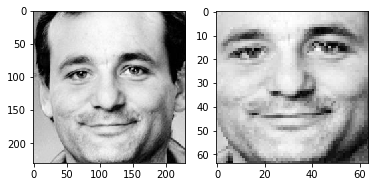

In [22]:
import numpy as np
import cv2
import time
from scipy.ndimage import zoom
img = cv2.imread('murray_smile_2eyes.jpg')

gray, facesFrontal = detect_faceFrontal(img)
grayProfile, facesProfile = detect_faceProfile(img)

t = time.time()

for (x, y, w, h) in facesFrontal:
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w] # original_extracted_face = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]

    new_extracted_face = extractFeatures(gray, x, y, w, h)

    # Check if calssifier predicts "happy" [1] or "not happy" [0]
    prediction_result = predict_face_is_happy(new_extracted_face)
    print("happy? [0 = NO; 1 = YES]: ", prediction_result)

    if prediction_result == 1:
        #cv2.putText(img, "HAPPY",(x,y), cv2.FONT_HERSHEY_SIMPLEX, 2, 155, 10)
        
        pirateHat(x, y, w, h, img)
        
        eyesFront = detect_eyesFrontal(roi_gray) # eye detection

        if len(eyesFront) >=2: # in case 2+ eyes are detected
            rightEye, leftEye = right_vs_left_eyes(eyesFront)

            # create ROI for right eye
            cv2.rectangle(roi_color,(eyesFront[rightEye,0],eyesFront[rightEye,1]),(eyesFront[rightEye,0]+eyesFront[rightEye,2],eyesFront[rightEye,1]+eyesFront[rightEye,3]),(0,255,0),2)
            # create ROI for left eye
            cv2.rectangle(roi_color,(eyesFront[leftEye,0],eyesFront[leftEye,1]),(eyesFront[leftEye,0]+eyesFront[leftEye,2],eyesFront[leftEye,1]+eyesFront[leftEye,3]),(0,255,0),2)

            piratePatchTwoEyes(eyesFront)

            # value to compare nose position (e.g. make sure nose is below ey)
            eyMin = min(eyesFront[rightEye,1],eyesFront[leftEye,1])
            eyBot = min(eyesFront[rightEye,1],eyesFront[leftEye,1]) + 1.5*min(eyesFront[rightEye,3],eyesFront[leftEye,3]) 
            exMin = eyesFront[rightEye,0] # ensure nose is to left of right eye
            exMax = eyesFront[leftEye,0] + eyesFront[leftEye,2]

        else: # if one eye is detected, put an eye patch on it
            for (ex,ey,ew,eh) in eyesFront:
                cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)

                piratePatchOneEye(eyesFront)

                eyMin = ey
                eyBot = ey + 1.5*eh
                exMin = int(w/8) # value to compare nose positions to
                exMax = int(w - w/8)

        nosesFront = detect_nosesFrontal(roi_gray) # nose detection
        for (nx,ny,nw,nh) in nosesFront:
            if ny > eyMin and nx > exMin and nx + nw < exMax and ny < eyBot:
                cv2.rectangle(roi_color,(nx,ny),(nx+nw,ny+nh),(0,255,0),2)

                pirateMustache(nx,ny,nw,nh) # add a pirate mustache

    else:
        #cv2.putText(img, "not happy",(x,y), cv2.FONT_HERSHEY_SIMPLEX, 2, 155, 10)

        evilHair(x, y, w, h, img)
        
        eyesFront = detect_eyesFrontal(roi_gray) # eye detection

        if len(eyesFront) >=2: # in case 2+ eyes are detected
            rightEye, leftEye = right_vs_left_eyes(eyesFront)

            # create ROI for right eye
            cv2.rectangle(roi_color,(eyesFront[rightEye,0],eyesFront[rightEye,1]),(eyesFront[rightEye,0]+eyesFront[rightEye,2],eyesFront[rightEye,1]+eyesFront[rightEye,3]),(0,255,0),2)
            # create ROI for left eye
            cv2.rectangle(roi_color,(eyesFront[leftEye,0],eyesFront[leftEye,1]),(eyesFront[leftEye,0]+eyesFront[leftEye,2],eyesFront[leftEye,1]+eyesFront[leftEye,3]),(0,255,0),2)

            evilTwoEyes(eyesFront)

            # value to compare nose position (e.g. make sure nose is below ey)
            eyMin = min(eyesFront[rightEye,1],eyesFront[leftEye,1])
            eyBot = min(eyesFront[rightEye,1],eyesFront[leftEye,1]) + 1.5*min(eyesFront[rightEye,3],eyesFront[leftEye,3]) 
            exMin = eyesFront[rightEye,0] # ensure nose is to left of right eye
            exMax = eyesFront[leftEye,0] + eyesFront[leftEye,2]

        else: # if one eye is detected
            for (ex,ey,ew,eh) in eyesFront:
                cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)

                evilOneEye(eyesFront)

                eyMin = ey
                eyBot = ey + 1.5*eh
                exMin = int(w/8) # value to compare nose positions to
                exMax = int(w - w/8)

        nosesFront = detect_nosesFrontal(roi_gray) # nose detection
        for (nx,ny,nw,nh) in nosesFront:
            if ny > eyMin and nx > exMin and nx + nw < exMax and ny < eyBot:
                cv2.rectangle(roi_color,(nx,ny),(nx+nw,ny+nh),(0,255,0),2)

                evilMustache(nx,ny,nw,nh) # add a pirate mustache
        
        elapsed = time.time() -t
        
    subplot(121); imshow(roi_gray, cmap = 'gray') # original extracted face
    subplot(122); imshow(new_extracted_face, cmap = 'gray') # extracted face for happy recognition
    
if len(facesFrontal) < 1:
    for (x, y, w, h) in facesProfile:
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        roi_gray = gray[y:y+h, x:x+w] # original_extracted_face = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
    
cv2.imshow('img',img)
cv2.waitKey(0)
cv2.destroyAllWindows()

## Real-Time Costume Creation

In [23]:
# Ahmed Webcam Debug

import numpy as np
import cv2

video = cv2.VideoCapture(0)

while(video.isOpened()):
    
    check, frame = video.read()
    
    cv2.imshow('Color Frame', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
video.release()
cv2.destroyAllWindows()

In [24]:
# Chakameh Webcam Debug

import cv2
video = cv2.VideoCapture(0)
if video.isOpened():
    while True:
        check, frame = video.read()
        if check:
            cv2.imshow('Color Framqe', frame)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        else:
            print('Frame not available')
            print(video.isOpened())

video.release()
cv2.destroyAllWindows()

In [25]:
def detect_faceFrontal(frame):
    face_cascadeFrontal = cv2.CascadeClassifier('C:\opencv\sources\data\haarcascades\haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    facesFrontal = face_cascadeFrontal.detectMultiScale(gray, scaleFactor = 1.1, minNeighbors = 6, minSize = (100, 100))
    return gray, facesFrontal

def detect_eyesFrontal(roi_gray):
    eye_cascadeFrontal = cv2.CascadeClassifier('C:\opencv\sources\data\haarcascades\haarcascade_eye.xml')
    eyesFront = eye_cascadeFrontal.detectMultiScale(roi_gray, scaleFactor = 1.1)
    return eyesFront
    
def detect_nosesFrontal(roi_gray):
    nose_Cascade = cv2.CascadeClassifier('C:\opencv\sources\data\haarcascades\haarcascade_mcs_nose.xml')
    nosesFront = nose_Cascade.detectMultiScale(roi_gray, scaleFactor = 1.1)
    return nosesFront    

def detect_faceProfile(frame):
    face_cascadeProfile = cv2.CascadeClassifier('C:\opencv\sources\data\haarcascades\haarcascade_profileface.xml')
    grayProfile = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    facesProfile = face_cascadeProfile.detectMultiScale(gray, scaleFactor = 1.1, minNeighbors = 6, minSize = (100, 100))
    return grayProfile, facesProfile    
    
def extractFeatures(gray, x, y, w, h):
    horizontal_offset = int(0.15 *w) 
    vertical_offset = int(0.2 * h)
    extracted_face = gray[y+vertical_offset:y+h, x+horizontal_offset:x-horizontal_offset+w]        
    # transform extracted img to 64 x 65 to match feature format of Olivetti dataset faces.
    new_extracted_face = zoom(extracted_face, (64. / extracted_face.shape[0], 
                                           64. / extracted_face.shape[1]))    
    new_extracted_face = new_extracted_face.astype(float32)
    new_extracted_face /= float(new_extracted_face.max())
    return new_extracted_face    
    
def predict_face_is_happy(extracted_face):
    B = extracted_face.reshape(1, -1)
    return svc_1.predict(B)   
        
def right_vs_left_eyes(eyesFront):
    x = np.array(eyesFront[:,1]); x1 = sorted(x); eyCutoff = x1[1]
    range1 = len(eyesFront)
    list1 = []; list2 = []; list3 = []
    for i in range(len(eyesFront)):
        for j in range(len(eyesFront)):
            if eyesFront[i,1] <= eyCutoff and eyesFront[j,1] <= eyCutoff and i !=j:
                list1.append(i) 
                list2.append(j)
            list3.append(abs(eyesFront[i,1]-eyesFront[j,1]))
    m = min(i for i in list3) # y-dist between two closest pairs of eyes
    pos = list3.index(m) # find 
    firstEye = list1[pos];  secondEye = list2[pos]

    # Determine which of the two eyes are the left and right eyes
    if eyesFront[firstEye,0] < eyesFront[secondEye,0]:
        rightEye = firstEye; leftEye = secondEye
    else:
        rightEye = secondEye; leftEye = firstEye  
    return rightEye, leftEye
    
def piratePatchTwoEyes(eyesFront):
    # Load overlay PiratePatch image: piratePatch.png
    imgPiratePatch = cv2.imread('piratePatch.png',-1)
    # Create PiratePatch mask
    orig_maskPiratePatch = imgPiratePatch[:,:,2]
    # Create inverted PiratePatch mask for the PiratePatch
    orig_mask_invPiratePatch = cv2.bitwise_not(orig_maskPiratePatch)
    imgPiratePatch = imgPiratePatch[:,:,0:3]
    origPiratePatchHeight, origPiratePatchWidth = imgPiratePatch.shape[:2]

    # Create pirate eye PiratePatch over left eye 
    PiratePatchWidth =  eyesFront[leftEye,2] # pirate eye path should be the width of the eye
    PiratePatchHeight = PiratePatchWidth * origPiratePatchHeight / origPiratePatchWidth # scale PiratePatch height to maintain aspect ratio
    # Determine the eye PiratePatch bounding regions
    x1 = eyesFront[leftEye,0] - (PiratePatchWidth/4)
    x2 = eyesFront[leftEye,0] + eyesFront[leftEye,2] + (PiratePatchWidth/4)
    y1 = eyesFront[leftEye,1] - (PiratePatchHeight/4)
    y2 = eyesFront[leftEye,1] + eyesFront[leftEye,3] + (PiratePatchHeight/4)
    # Cast coordinates as integers 
    x1 = int(x1); x2 = int(x2); y1 = int(y1);  y2 = int(y2)
    # Check for clipping
    if x1 < 0:
        x1 = 0
    if y1 < 0:
        y1 = 0
    if x2 > w:
        x2 = w
    if y2 > h:
        y2 = h
    # Re-calculate eye PiratePatch width and height
    PiratePatchWidth = x2 - x1; PiratePatchHeight = y2 - y1;
    # Re-size the original PiratePatch image and the masks to the new PiratePatch size
    PiratePatch = cv2.resize(imgPiratePatch, (PiratePatchWidth,PiratePatchHeight), interpolation = cv2.INTER_AREA)
    mask = cv2.resize(orig_maskPiratePatch, (PiratePatchWidth,PiratePatchHeight), interpolation = cv2.INTER_AREA)
    mask_inv = cv2.resize(orig_mask_invPiratePatch, (PiratePatchWidth,PiratePatchHeight), interpolation = cv2.INTER_AREA)
    # take ROI for eye PiratePatch from background equal to size of path image
    roi = roi_color[y1:y2, x1:x2]
    # roi_bg contains the original image only where the PiratePatch is not ...
    # in the region that is the size of the PiratePatch.
    roi_bg = cv2.bitwise_and(roi,roi,mask = mask_inv)
    # roi_fg contains the image of the PiratePatch only where the path is
    roi_fg = cv2.bitwise_and(PiratePatch,PiratePatch,mask = mask)
    # join roi_bg and roi_fg
    dst = cv2.add(roi_bg,roi_fg)
    # place the joined image, saved to dst back over the original image
    roi_color[y1:y2, x1:x2] = dst  
    
def piratePatchOneEye(eyesFront):
    # Load overlay patch image: piratePatch.png
    imgPatch = cv2.imread('piratePatch.png',-1)
    # Create patch mask
    orig_maskPatch = imgPatch[:,:,2]
    # Create inverted patch mask for the patch
    orig_mask_invPatch = cv2.bitwise_not(orig_maskPatch)
    imgPatch = imgPatch[:,:,0:3]
    origPatchHeight, origPatchWidth = imgPatch.shape[:2]
    
    # add a pirate eye patch
    patchWidth =  eyesFront[0,2] # pirate eye path should be the width of the eye
    patchHeight = patchWidth * origPatchHeight / origPatchWidth # scale patch height to maintain aspect ratio
    # Determine the eye patch bounding regions
    x1 = eyesFront[0,0] - (patchWidth/4)
    x2 = eyesFront[0,0] + eyesFront[0,2] + (patchWidth/4)
    y1 = eyesFront[0,1] - (patchHeight/4)
    y2 = eyesFront[0,1] + eyesFront[0,3] + (0/4)
    # Cast coordinates as integers 
    x1 = int(x1); x2 = int(x2); y1 = int(y1);  y2 = int(y2)
    # Check for clipping
    if x1 < 0:
        x1 = 0
    if y1 < 0:
        y1 = 0
    if x2 > w:
        x2 = w
    if y2 > h:
        y2 = h
    # Re-calculate eye patch width and height
    patchWidth = x2 - x1; patchHeight = y2 - y1;
    # Re-size the original patch image and the masks to the new patch size
    patch = cv2.resize(imgPatch, (patchWidth,patchHeight), interpolation = cv2.INTER_AREA)
    mask = cv2.resize(orig_maskPatch, (patchWidth,patchHeight), interpolation = cv2.INTER_AREA)
    mask_inv = cv2.resize(orig_mask_invPatch, (patchWidth,patchHeight), interpolation = cv2.INTER_AREA)
    # take ROI for eye patch from background equal to size of path image
    roi = roi_color[y1:y2, x1:x2]
    # roi_bg contains the original image only where the patch is not ...
    # in the region that is the size of the patch.
    roi_bg = cv2.bitwise_and(roi,roi,mask = mask_inv)
    # roi_fg contains the image of the patch only where the patch is
    roi_fg = cv2.bitwise_and(patch,patch,mask = mask)
    # join roi_bg and roi_fg
    dst = cv2.add(roi_bg,roi_fg)
    # place the joined image, saved to dst back over the original image
    roi_color[y1:y2, x1:x2] = dst      
    
    
def pirateMustache(nx, ny, nw, nh):    
    # Load overlay mustache image: pirateMustache.png
    imgMustache = cv2.imread('pirateMustache.png',-1)
    # Create mustache mask
    orig_mask = imgMustache[:,:,3]
    # Create inverted mustache mask
    orig_mask_inv = cv2.bitwise_not(orig_mask)
    # Convert mustache img to BGR; and save original img size (used later when re-sizing img)
    imgMustache = imgMustache[:,:,0:3]
    origMustacheHeight, origMustacheWidth = imgMustache.shape[:2]

    # Create Mustache
    mustacheWidth =  3 * nw # mustache width is 3x nose width
    mustacheHeight = mustacheWidth * origMustacheHeight / origMustacheWidth # maintain mustache aspect ratio
    # Center mustache on bottom of nose
    x1 = nx - (mustacheWidth/4)
    x2 = nx + nw + (mustacheWidth/4)
    y1 = ny + nh - (mustacheHeight/2)
    y2 = ny + nh + (mustacheHeight/2)
    # Cast coordinates as integers
    x1 = int(x1); x2 = int(x2); y1 = int(y1);  y2 = int(y2)
    # Check for clipping
    if x1 < 0:
        x1 = 0
    if y1 < 0:
        y1 = 0
    if x2 > w:
        x2 = w
    if y2 > h:
        y2 = h
    # Re-calculate mustache width and height
    mustacheWidth = x2 - x1; mustacheHeight = y2 - y1
    # Re-size the original mustache img and the masks to the new mustache size
    mustache = cv2.resize(imgMustache, (mustacheWidth,mustacheHeight), interpolation = cv2.INTER_AREA)
    mask = cv2.resize(orig_mask, (mustacheWidth,mustacheHeight), interpolation = cv2.INTER_AREA)
    mask_inv = cv2.resize(orig_mask_inv, (mustacheWidth,mustacheHeight), interpolation = cv2.INTER_AREA)
    # take ROI for mustache from background equal to size of mustache image
    roi = roi_color[y1:y2, x1:x2]
    # roi_bg contains the original image only where the mustache is ...
    # ... not in the region that is the size of the mustache.
    roi_bg = cv2.bitwise_and(roi,roi,mask = mask_inv)
    # roi_fg contains the image of the mustache only where the mustache is
    roi_fg = cv2.bitwise_and(mustache,mustache,mask = mask)
    # join roi_bg and roi_fg
    dst = cv2.add(roi_bg,roi_fg)
    # place the joined image, saved to dst back over the original image
    roi_color[y1:y2, x1:x2] = dst

def pirateHat(x, y, w, h, img):    
    # Load overlay pirateHat image: pirateHat.png
    imgPirateHat = cv2.imread('pirateHat.png',-1)
    # Create pirateHat mask
    orig_mask = imgPirateHat[:,:,3]
    # Create inverted pirateHat mask
    orig_mask_inv = cv2.bitwise_not(orig_mask)
    # Convert pirateHat img to BGR; and save original img size (used later when re-sizing img)
    imgPirateHat = imgPirateHat[:,:,0:3]
    origPirateHatHeight, origPirateHatWidth = imgPirateHat.shape[:2]

    # Create pirateHat
    pirateHatWidth =  1 * w # pirateHat width is 3x nose width
    pirateHatHeight = pirateHatWidth * origPirateHatHeight / origPirateHatWidth # maintain pirateHat aspect ratio
    # Center pirateHat on bottom of nose
    x1 = x - (pirateHatWidth/8)
    x2 = x + w + (pirateHatWidth/8)
    y1 = y - (pirateHatHeight/1.5)
    y2 = y + (pirateHatHeight/4)
    # Cast coordinates as integers
    x1 = int(x1); x2 = int(x2); y1 = int(y1);  y2 = int(y2)
    # Check for clipping
    if x1 < 0:
        x1 = 0
    if y1 < 0:
        y1 = 0
    if x2 > img.shape[1]:
        x2 = img.shape[1]
    if y2 > img.shape[0]:
        y2 = img.shape[0]
    # Re-calculate pirateHat width and height
    pirateHatWidth = x2 - x1; pirateHatHeight = y2 - y1
    # Re-size the original pirateHat img and the masks to the new pirateHat size
    pirateHat = cv2.resize(imgPirateHat, (pirateHatWidth,pirateHatHeight), interpolation = cv2.INTER_AREA)
    mask = cv2.resize(orig_mask, (pirateHatWidth,pirateHatHeight), interpolation = cv2.INTER_AREA)
    mask_inv = cv2.resize(orig_mask_inv, (pirateHatWidth,pirateHatHeight), interpolation = cv2.INTER_AREA)
    # take ROI for pirateHat from background equal to size of pirateHat image
    roi = img[y1:y2, x1:x2]
    # roi_bg contains the original image only where the pirateHat is ...
    # ... not in the region that is the size of the pirateHat.
    roi_bg = cv2.bitwise_and(roi,roi,mask = mask_inv)
    # roi_fg contains the image of the pirateHat only where the pirateHat is
    roi_fg = cv2.bitwise_and(pirateHat,pirateHat,mask = mask)
    # join roi_bg and roi_fg
    dst = cv2.add(roi_bg,roi_fg)
    # place the joined image, saved to dst back over the original image
    img[y1:y2, x1:x2] = dst
    
def evilTwoEyes(eyesFront):
    # Load overlay EvilEye image: EvilEye.png
    imgEvilEye = cv2.imread('evilEye.png',-1)
    # Create EvilEye mask
    orig_maskEvilEye = imgEvilEye[:,:,2]
    # Create inverted EvilEye mask for the EvilEye
    orig_mask_invEvilEye = cv2.bitwise_not(orig_maskEvilEye)
    imgEvilEye = imgEvilEye[:,:,0:3]
    origEvilEyeHeight, origEvilEyeWidth = imgEvilEye.shape[:2]

    # Create pirate eye EvilEye over left eye 
    EvilEyeWidth =  eyesFront[leftEye,2] # pirate eye path should be the width of the eye
    EvilEyeHeight = EvilEyeWidth * origEvilEyeHeight / origEvilEyeWidth # scale EvilEye height to maintain aspect ratio
    # Determine the eye EvilEye bounding regions
    x1 = eyesFront[leftEye,0] - (EvilEyeWidth/8)
    x2 = eyesFront[leftEye,0] + eyesFront[leftEye,2] + (EvilEyeWidth/8)
    y1 = eyesFront[leftEye,1] - (EvilEyeHeight/8)
    y2 = eyesFront[leftEye,1] + eyesFront[leftEye,3] + (EvilEyeHeight/8)
    # Cast coordinates as integers 
    x1 = int(x1); x2 = int(x2); y1 = int(y1);  y2 = int(y2)
    # Check for clipping
    if x1 < 0:
        x1 = 0
    if y1 < 0:
        y1 = 0
    if x2 > w:
        x2 = w
    if y2 > h:
        y2 = h
    # Re-calculate eye EvilEye width and height
    EvilEyeWidth = x2 - x1; EvilEyeHeight = y2 - y1;
    # Re-size the original EvilEye image and the masks to the new EvilEye size
    EvilEye = cv2.resize(imgEvilEye, (EvilEyeWidth,EvilEyeHeight), interpolation = cv2.INTER_AREA)
    mask = cv2.resize(orig_maskEvilEye, (EvilEyeWidth,EvilEyeHeight), interpolation = cv2.INTER_AREA)
    mask_inv = cv2.resize(orig_mask_invEvilEye, (EvilEyeWidth,EvilEyeHeight), interpolation = cv2.INTER_AREA)
    # take ROI for eye EvilEye from background equal to size of path image
    roi = roi_color[y1:y2, x1:x2]
    # roi_bg contains the original image only where the EvilEye is not ...
    # in the region that is the size of the EvilEye.
    roi_bg = cv2.bitwise_and(roi,roi,mask = mask_inv)
    # roi_fg contains the image of the EvilEye only where the path is
    roi_fg = cv2.bitwise_and(EvilEye,EvilEye,mask = mask)
    # join roi_bg and roi_fg
    dst = cv2.add(roi_bg,roi_fg)
    # place the joined image, saved to dst back over the original image
    roi_color[y1:y2, x1:x2] = dst   
    
def evilOneEye(eyesFront):
    # Load overlay EvilEye image: EvilEye.png
    imgEvilEye = cv2.imread('evilEye.png',-1)
    # Create EvilEye mask
    orig_maskEvilEye = imgEvilEye[:,:,2]
    # Create inverted EvilEye mask for the EvilEye
    orig_mask_invEvilEye = cv2.bitwise_not(orig_maskEvilEye)
    imgEvilEye = imgEvilEye[:,:,0:3]
    origEvilEyeHeight, origEvilEyeWidth = imgEvilEye.shape[:2]
    
    # add a pirate eye EvilEye
    EvilEyeWidth =  eyesFront[0,2] # pirate eye path should be the width of the eye
    EvilEyeHeight = EvilEyeWidth * origEvilEyeHeight / origEvilEyeWidth # scale EvilEye height to maintain aspect ratio
    # Determine the eye EvilEye bounding regions
    x1 = eyesFront[0,0] - (EvilEyeWidth/8)
    x2 = eyesFront[0,0] + eyesFront[0,2] + (EvilEyeWidth/8)
    y1 = eyesFront[0,1] - (EvilEyeHeight/8)
    y2 = eyesFront[0,1] + eyesFront[0,3] + (0/8)
    # Cast coordinates as integers 
    x1 = int(x1); x2 = int(x2); y1 = int(y1);  y2 = int(y2)
    # Check for clipping
    if x1 < 0:
        x1 = 0
    if y1 < 0:
        y1 = 0
    if x2 > w:
        x2 = w
    if y2 > h:
        y2 = h
    # Re-calculate eye EvilEye width and height
    EvilEyeWidth = x2 - x1; EvilEyeHeight = y2 - y1;
    # Re-size the original EvilEye image and the masks to the new EvilEye size
    EvilEye = cv2.resize(imgEvilEye, (EvilEyeWidth,EvilEyeHeight), interpolation = cv2.INTER_AREA)
    mask = cv2.resize(orig_maskEvilEye, (EvilEyeWidth,EvilEyeHeight), interpolation = cv2.INTER_AREA)
    mask_inv = cv2.resize(orig_mask_invEvilEye, (EvilEyeWidth,EvilEyeHeight), interpolation = cv2.INTER_AREA)
    # take ROI for eye EvilEye from background equal to size of path image
    roi = roi_color[y1:y2, x1:x2]
    # roi_bg contains the original image only where the EvilEye is not ...
    # in the region that is the size of the EvilEye.
    roi_bg = cv2.bitwise_and(roi,roi,mask = mask_inv)
    # roi_fg contains the image of the EvilEye only where the EvilEye is
    roi_fg = cv2.bitwise_and(EvilEye,EvilEye,mask = mask)
    # join roi_bg and roi_fg
    dst = cv2.add(roi_bg,roi_fg)
    # place the joined image, saved to dst back over the original image
    roi_color[y1:y2, x1:x2] = dst    
    
def evilMustache(nx, ny, nw, nh):    
    # Load overlay mustache image: mustache.png
    imgMustache = cv2.imread('evilMustache.png',-1)
    # Create mustache mask
    orig_mask = imgMustache[:,:,2]
    # Create inverted mustache mask
    orig_mask_inv = cv2.bitwise_not(orig_mask)
    # Convert mustache img to BGR; and save original img size (used later when re-sizing img)
    imgMustache = imgMustache[:,:,0:3]
    origMustacheHeight, origMustacheWidth = imgMustache.shape[:2]

    # Create Mustache
    mustacheWidth =  3 * nw # mustache width is 3x nose width
    mustacheHeight = mustacheWidth * origMustacheHeight / origMustacheWidth # maintain mustache aspect ratio
    # Center mustache on bottom of nose
    x1 = nx - (mustacheWidth/8)
    x2 = nx + nw + (mustacheWidth/8)
    y1 = ny + nh - (mustacheHeight/4)
    y2 = ny + nh + (mustacheHeight/4)
    # Cast coordinates as integers
    x1 = int(x1); x2 = int(x2); y1 = int(y1);  y2 = int(y2)
    # Check for clipping
    if x1 < 0:
        x1 = 0
    if y1 < 0:
        y1 = 0
    if x2 > w:
        x2 = w
    if y2 > h:
        y2 = h
    # Re-calculate mustache width and height
    mustacheWidth = x2 - x1; mustacheHeight = y2 - y1
    # Re-size the original mustache img and the masks to the new mustache size
    mustache = cv2.resize(imgMustache, (mustacheWidth,mustacheHeight), interpolation = cv2.INTER_AREA)
    mask = cv2.resize(orig_mask, (mustacheWidth,mustacheHeight), interpolation = cv2.INTER_AREA)
    mask_inv = cv2.resize(orig_mask_inv, (mustacheWidth,mustacheHeight), interpolation = cv2.INTER_AREA)
    # take ROI for mustache from background equal to size of mustache image
    roi = roi_color[y1:y2, x1:x2]
    # roi_bg contains the original image only where the mustache is ...
    # ... not in the region that is the size of the mustache.
    roi_bg = cv2.bitwise_and(roi,roi,mask = mask_inv)
    # roi_fg contains the image of the mustache only where the mustache is
    roi_fg = cv2.bitwise_and(mustache,mustache,mask = mask)
    # join roi_bg and roi_fg
    dst = cv2.add(roi_bg,roi_fg)
    # place the joined image, saved to dst back over the original image
    roi_color[y1:y2, x1:x2] = dst   
        
def evilHair(x, y, w, h, img):    
    # Load overlay EvilHair image: evilHair.png
    imgEvilHair = cv2.imread('evilHair.png',-1)
    # Create EvilHair mask
    orig_mask = imgEvilHair[:,:,2]
    # Create inverted EvilHair mask
    orig_mask_inv = cv2.bitwise_not(orig_mask)
    # Convert EvilHair img to BGR; and save original img size (used later when re-sizing img)
    imgEvilHair = imgEvilHair[:,:,0:3]
    origEvilHairHeight, origEvilHairWidth = imgEvilHair.shape[:2]

    # Create EvilHair
    EvilHairWidth =  1 * w # EvilHair width is 3x nose width
    EvilHairHeight = EvilHairWidth * origEvilHairHeight / origEvilHairWidth # maintain EvilHair aspect ratio
    # Center EvilHair on bottom of nose
    x1 = x #- (EvilHairWidth/8)
    x2 = x + w #+ (EvilHairWidth/8)
    y1 = y - (EvilHairHeight/1.5)
    y2 = y + (EvilHairHeight/1.5)
    # Cast coordinates as integers
    x1 = int(x1); x2 = int(x2); y1 = int(y1);  y2 = int(y2)
    # Check for clipping
    if x1 < 0:
        x1 = 0
    if y1 < 0:
        y1 = 0
    if x2 > img.shape[1]:
        x2 = img.shape[1]
    if y2 > img.shape[0]:
        y2 = img.shape[0]
    # Re-calculate EvilHair width and height
    EvilHairWidth = x2 - x1; EvilHairHeight = y2 - y1
    # Re-size the original EvilHair img and the masks to the new EvilHair size
    EvilHair = cv2.resize(imgEvilHair, (EvilHairWidth,EvilHairHeight), interpolation = cv2.INTER_AREA)
    mask = cv2.resize(orig_mask, (EvilHairWidth,EvilHairHeight), interpolation = cv2.INTER_AREA)
    mask_inv = cv2.resize(orig_mask_inv, (EvilHairWidth,EvilHairHeight), interpolation = cv2.INTER_AREA)
    # take ROI for EvilHair from background equal to size of EvilHair image
    roi = img[y1:y2, x1:x2]
    # roi_bg contains the original image only where the EvilHair is ...
    # ... not in the region that is the size of the EvilHair.
    roi_bg = cv2.bitwise_and(roi,roi,mask = mask_inv)
    # roi_fg contains the image of the EvilHair only where the EvilHair is
    roi_fg = cv2.bitwise_and(EvilHair,EvilHair,mask = mask)
    # join roi_bg and roi_fg
    dst = cv2.add(roi_bg,roi_fg)
    # place the joined image, saved to dst back over the original image
    img[y1:y2, x1:x2] = dst 

In [26]:
import cv2
import numpy as np
from scipy.ndimage import zoom
%matplotlib inline 
from pylab import *
    
video = cv2.VideoCapture(0)
while True:
    # Capture frame-by-frame
    ret, frame = video.read()

    # detect faces
    gray, facesFrontal = detect_faceFrontal(frame)
    #grayProfile, facesProfile = detect_faceProfile(frame)
    face_index = 0
    
    # predict output
    for (x, y, w, h) in facesFrontal:
        cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)
        roi_gray = gray[y:y+h, x:x+w] # original_extracted_face = gray[y:y+h, x:x+w]
        roi_color = frame[y:y+h, x:x+w]

        new_extracted_face = extractFeatures(gray, x, y, w, h)
        
        # Check if calssifier predicts "happy" [1] or "not happy" [0]
        prediction_result = predict_face_is_happy(new_extracted_face)
        
        frame[face_index * 64: (face_index + 1) * 64, -65:-1, :] = cv2.cvtColor(new_extracted_face * 255, cv2.COLOR_GRAY2RGB)
        
        if prediction_result == 1:
            cv2.putText(frame, "HAPPY",(x,y), cv2.FONT_HERSHEY_SIMPLEX, 2, 155, 10)
            
            pirateHat(x, y, w, h, frame)
            
            eyesFront = detect_eyesFrontal(roi_gray) # eye detection

            if len(eyesFront) >=2: # in case 2+ eyes are detected
                rightEye, leftEye = right_vs_left_eyes(eyesFront)
                
                # create ROI for right eye
                cv2.rectangle(roi_color,(eyesFront[rightEye,0],eyesFront[rightEye,1]),(eyesFront[rightEye,0]+eyesFront[rightEye,2],eyesFront[rightEye,1]+eyesFront[rightEye,3]),(0,255,0),2)
                # create ROI for left eye
                cv2.rectangle(roi_color,(eyesFront[leftEye,0],eyesFront[leftEye,1]),(eyesFront[leftEye,0]+eyesFront[leftEye,2],eyesFront[leftEye,1]+eyesFront[leftEye,3]),(0,255,0),2)

                piratePatchTwoEyes(eyesFront)
                
                # value to compare nose position (e.g. make sure nose is below ey)
                eyMin = min(eyesFront[rightEye,1],eyesFront[leftEye,1])
                eyBot = min(eyesFront[rightEye,1],eyesFront[leftEye,1]) + 1.5*min(eyesFront[rightEye,3],eyesFront[leftEye,3]) 
                exMin = eyesFront[rightEye,0] # ensure nose is to left of right eye
                exMax = eyesFront[leftEye,0] + eyesFront[leftEye,2]
                
                
            else: # if one eye is detected, put an eye patch on it
                for (ex,ey,ew,eh) in eyesFront:
                    cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)

                    piratePatchOneEye(eyesFront)

                    eyMin = ey
                    eyBot = ey + 1.5*eh
                    exMin = int(w/8) # value to compare nose positions to
                    exMax = int(w - w/8)
            
            nosesFront = detect_nosesFrontal(roi_gray) # nose detection
            for (nx,ny,nw,nh) in nosesFront:
                if ny > eyMin and nx > exMin and nx + nw < exMax and ny < eyBot:
                    cv2.rectangle(roi_color,(nx,ny),(nx+nw,ny+nh),(0,255,0),2)

                    pirateMustache(nx,ny,nw,nh) # add a pirate mustache
                  
        else:
            #cv2.putText(img, "not happy",(x,y), cv2.FONT_HERSHEY_SIMPLEX, 2, 155, 10)
            
            evilHair(x, y, w, h, frame)
            
            eyesFront = detect_eyesFrontal(roi_gray) # eye detection
            
            
            if len(eyesFront) >=2: # in case 2+ eyes are detected
                rightEye, leftEye = right_vs_left_eyes(eyesFront)

                # create ROI for right eye
                cv2.rectangle(roi_color,(eyesFront[rightEye,0],eyesFront[rightEye,1]),(eyesFront[rightEye,0]+eyesFront[rightEye,2],eyesFront[rightEye,1]+eyesFront[rightEye,3]),(0,255,0),2)
                # create ROI for left eye
                cv2.rectangle(roi_color,(eyesFront[leftEye,0],eyesFront[leftEye,1]),(eyesFront[leftEye,0]+eyesFront[leftEye,2],eyesFront[leftEye,1]+eyesFront[leftEye,3]),(0,255,0),2)

                evilTwoEyes(eyesFront)

                # value to compare nose position (e.g. make sure nose is below ey)
                eyMin = min(eyesFront[rightEye,1],eyesFront[leftEye,1])
                eyBot = min(eyesFront[rightEye,1],eyesFront[leftEye,1]) + 1.5*min(eyesFront[rightEye,3],eyesFront[leftEye,3]) 
                exMin = eyesFront[rightEye,0] # ensure nose is to left of right eye
                exMax = eyesFront[leftEye,0] + eyesFront[leftEye,2]
                
                
            else: # if one eye is detected
                for (ex,ey,ew,eh) in eyesFront:
                    cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)

                    evilOneEye(eyesFront)

                    eyMin = ey
                    eyBot = ey + 1.5*eh
                    exMin = int(w/8) # value to compare nose positions to
             
            nosesFront = detect_nosesFrontal(roi_gray) # nose detection
            for (nx,ny,nw,nh) in nosesFront:
                if ny > eyMin and nx > exMin and nx + nw < exMax and ny < eyBot:
                    cv2.rectangle(roi_color,(nx,ny),(nx+nw,ny+nh),(0,255,0),2)

                    evilMustache(nx,ny,nw,nh) # add a pirate mustache
                    
                    
        face_index += 1
    
#    if len(facesFrontal) < 1:
#        for (x, y, w, h) in facesProfile:
#            cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
#            roi_gray = gray[y:y+h, x:x+w] # original_extracted_face = gray[y:y+h, x:x+w]
#            roi_color = img[y:y+h, x:x+w]            
            
            
    cv2.imshow('Video', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything is done, release the capture
video.release()
cv2.destroyAllWindows()
